## Import the Required Library

In [3]:
import pandas as pd
import numpy as np
import os
import random

## Mount Google Drive and Load the Datasets

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
%cd '/content/drive/MyDrive/datasets/assessment_datasets'

/content/drive/MyDrive/datasets/assessment_datasets


In [4]:
%ls

air_quality_data_combined.csv                 PRSA_Data_Gucheng_20130301-20170228.csv
combined_output.csv                           PRSA_Data_Huairou_20130301-20170228.csv
PRSA_Data_Aotizhongxin_20130301-20170228.csv  PRSA_Data_Nongzhanguan_20130301-20170228.csv
PRSA_Data_Changping_20130301-20170228.csv     PRSA_Data_Shunyi_20130301-20170228.csv
PRSA_Data_Dingling_20130301-20170228.csv      PRSA_Data_Tiantan_20130301-20170228.csv
PRSA_Data_Dongsi_20130301-20170228.csv        PRSA_Data_Wanliu_20130301-20170228.csv
PRSA_Data_Guanyuan_20130301-20170228.csv      PRSA_Data_Wanshouxigong_20130301-20170228.csv


In [6]:
# Get all files in the folder
files = os.listdir()

# Filter only CSV files that start with "PRSA_Data_"
csv_files = [file for file in files if file.startswith("PRSA_Data_") and file.endswith(".csv")]

# Choose 5 random CSV files
random_csv_files = random.sample(csv_files, 5)
selected_stations = [csv_file.split('_')[2] for csv_file in random_csv_files]

# Read and combine random selected CSV files
combined_df = pd.concat([pd.read_csv(file) for file in random_csv_files], ignore_index=True)

# Save to a new CSV file
combined_df.to_csv("air_quality_data_combined.csv", index=False)

print(f"CSV files containing {selected_stations} station have been merged into 'air_quality_data_combined.csv'.")

CSV files containing ['Nongzhanguan', 'Changping', 'Wanshouxigong', 'Gucheng', 'Guanyuan'] station have been merged into 'air_quality_data_combined.csv'.


In [6]:
df = pd.read_csv("air_quality_data_combined.csv")
print(f"DataFrame shape is: {df.shape}")
df.head()

DataFrame shape is: (175320, 18)


,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,1,2013,3,1,0,5.0,14.0,4.0,12.0,200.0,85.0,-0.5,1024.5,-21.4,0.0,NNW,5.7,Nongzhanguan
1,2,2013,3,1,1,8.0,12.0,6.0,14.0,200.0,84.0,-0.7,1025.1,-22.1,0.0,NW,3.9,Nongzhanguan
2,3,2013,3,1,2,3.0,6.0,5.0,14.0,200.0,83.0,-1.2,1025.3,-24.6,0.0,NNW,5.3,Nongzhanguan
3,4,2013,3,1,3,5.0,5.0,5.0,14.0,200.0,84.0,-1.4,1026.2,-25.5,0.0,N,4.9,Nongzhanguan
4,5,2013,3,1,4,5.0,5.0,6.0,21.0,200.0,77.0,-1.9,1027.1,-24.5,0.0,NNW,3.2,Nongzhanguan


In [7]:
df['station'].value_counts()

,count
station,
Nongzhanguan,35064
Changping,35064
Wanshouxigong,35064
Gucheng,35064
Guanyuan,35064


## Data Preprocessing

In [8]:
#print data types
df_types = pd.DataFrame([df.dtypes], columns=df.columns)
df_types

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,float64,object


#### Merge `year`, `month`, `day`, `hour` into `timestamp` and drop them. Convert it into datetime and set as index.

Converting the `year`, `month`, `day`, and `hour` into a datetime `timestamp` and using it as the index simplifies the data structure and enhances analysis. It allows for efficient time-based operations like filtering, resampling, and time series analysis. Storing the data as datetime reduces memory usage and ensures consistency, making it easier to work with time-related calculations. Using it as the index also helps in sorting and accessing data by specific time intervals, improving the overall efficiency of time-based analyses and visualizations.

In [9]:
# Create `timestamp` column
df['timestamp'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])

# Set `timestamp` as the index
df = df.set_index('timestamp')

# Drop `No`, `year`, `month`, `day`, `hour` columns
df = df.drop(['No', 'year', 'month', 'day', 'hour'], axis=1)

df.head()

,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
timestamp,,,,,,,,,,,,,
2013-03-01 00:00:00,5.0,14.0,4.0,12.0,200.0,85.0,-0.5,1024.5,-21.4,0.0,NNW,5.7,Nongzhanguan
2013-03-01 01:00:00,8.0,12.0,6.0,14.0,200.0,84.0,-0.7,1025.1,-22.1,0.0,NW,3.9,Nongzhanguan
2013-03-01 02:00:00,3.0,6.0,5.0,14.0,200.0,83.0,-1.2,1025.3,-24.6,0.0,NNW,5.3,Nongzhanguan
2013-03-01 03:00:00,5.0,5.0,5.0,14.0,200.0,84.0,-1.4,1026.2,-25.5,0.0,N,4.9,Nongzhanguan
2013-03-01 04:00:00,5.0,5.0,6.0,21.0,200.0,77.0,-1.9,1027.1,-24.5,0.0,NNW,3.2,Nongzhanguan


#### Inspect missing value and count

In [10]:
missing_values = pd.DataFrame([df.isna().sum(), ((df.isna().sum() / len(df))*100).round(3)], columns=df.columns)
missing_values.index = ['Count', 'Percentage']
missing_values

,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
Count,3360.000,2316.000,2724.000,3440.000,7178.000,4090.000,163.000,159.000,163.000,153.000,537.000,126.000,0.0
Percentage,1.916,1.321,1.554,1.962,4.094,2.333,0.093,0.091,0.093,0.087,0.306,0.072,0.0


Since the percentage of missing values in the dataset is `less than 5%`, dropping rows with missing data is a reasonable approach. The small proportion of missing values means that removing these rows will not significantly impact the overall dataset, and it helps maintain the integrity of the data by avoiding potential biases introduced by imputation. This ensures that the analysis remains accurate and can work with clean, complete data without introducing assumptions or uncertainty.

In [11]:
# Drop missing rows
print(f'Shape before dropping missing values: {df.shape}')
df = df.dropna(axis=0)
print(f'Shape after dropping missing values: {df.shape}')

Shape before dropping missing values: (175320, 13)
Shape after dropping missing values: (163330, 13)


In [12]:
# Inspect missing values again
missing_values = pd.DataFrame([df.isna().sum(), ((df.isna().sum() / len(df))*100).round(3)], columns=df.columns)
missing_values.index = ['Count', 'Percentage']
missing_values

,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
Count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Percentage,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Calculate AQI (air quality index)

The Air Quality Index (AQI) is calculated by measuring the concentration of pollutants like ozone, particulate matter, sulfur dioxide, nitrogen dioxide, and carbon monoxide, then determining the highest sub-index value among these pollutants, which becomes the overall AQI.
[AQI on Wikipedia](https://en.wikipedia.org/wiki/Air_quality_index)

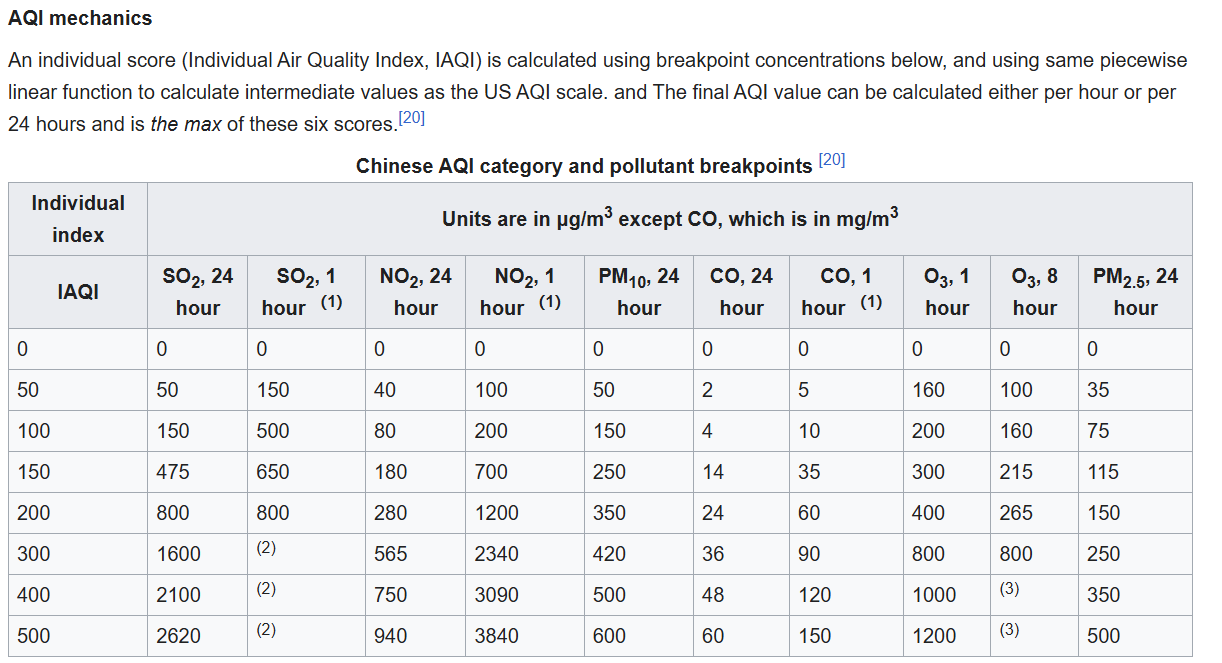

In [13]:
breakpoints_pm25_per_day = [(0, 35, 0, 50), (35, 75, 51, 100), (75, 115, 101, 150), (115, 150, 151, 200),
                    (150, 250, 201, 300), (250, 350, 301, 400), (350, 500, 401, 500)]

breakpoints_pm10_per_day = [(0, 50, 0, 50), (51, 150, 51, 100), (151, 250, 101, 150), (251, 350, 151, 200),
                    (350, 420, 201, 300), (420, 500, 301, 400), (500, 600, 401, 500)]

breakpoints_so2_per_hour = [(0, 150, 0, 50), (151, 500, 51, 100), (501, 650, 101, 150), (651, 800, 151, 200),
                   (801, 1600, 201, 300), (1601, 2100, 301, 400), (2100, 2620, 401, 500)]

breakpoints_no2_per_hour = [(0, 100, 0, 50), (101, 200, 51, 100), (201, 700, 101, 150), (701, 1200, 151, 200),
                   (1201, 2340, 201, 300), (2341, 3090, 301, 400), (3091, 3840, 401, 500)]

breakpoints_co_per_hour = [(0, 5000, 0, 50), (5001, 10000, 51, 100), (10001, 35000, 101, 150), (35001, 60000, 151, 200),
                  (60001, 90000, 201, 300), (90001, 120000, 301, 400), (120001, 150000, 401, 500)]

breakpoints_o3_per_hour = [(0, 160, 0, 50), (161, 200, 51, 100), (201, 300, 101, 150), (301, 400, 151, 200),
                  (401, 800, 201, 300), (801, 1000, 301, 400), (1001, 1200, 401, 500)]

The Air Quality Index (AQI) is calculated using a formula that converts measured pollutant concentrations into a single index value, with the highest sub-index value determining the overall AQI.



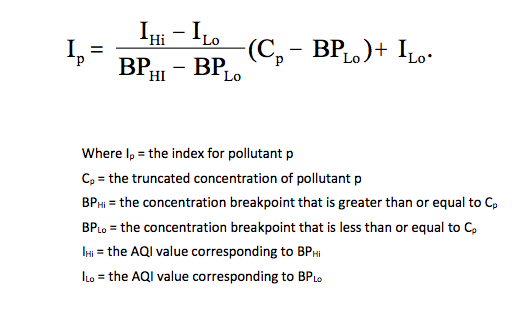

In [16]:
def calculate_aqi(conc, breakpoints):
    for C_low, C_high, I_low, I_high in breakpoints:
        if C_low <= conc <= C_high:
            return ((I_high - I_low) / (C_high - C_low)) * (conc - C_low) + I_low
    return np.nan

# 24-hour averages for PM2.5 and PM10
df['PM2.5_24h'] = df['PM2.5'].rolling(window=24, min_periods=1).mean()
df['PM10_24h'] = df['PM10'].rolling(window=24, min_periods=1).mean()

# AQI per pollutant
df['AQI_PM25'] = df['PM2.5_24h'].apply(lambda x: calculate_aqi(x, breakpoints_pm25_per_day))
df['AQI_PM10'] = df['PM10_24h'].apply(lambda x: calculate_aqi(x, breakpoints_pm10_per_day))
df['AQI_SO2'] = df['SO2'].apply(lambda x: calculate_aqi(x, breakpoints_so2_per_hour))
df['AQI_NO2'] = df['NO2'].apply(lambda x: calculate_aqi(x, breakpoints_no2_per_hour))
df['AQI_CO'] = df['CO'].apply(lambda x: calculate_aqi(x, breakpoints_co_per_hour))
df['AQI_O3'] = df['O3'].apply(lambda x: calculate_aqi(x, breakpoints_o3_per_hour))

# Final AQI: max value among all pollutants
df['AQI'] = df[['AQI_PM25', 'AQI_PM10', 'AQI_SO2', 'AQI_NO2', 'AQI_CO', 'AQI_O3']].max(axis=1).round()

df[['AQI_PM25', 'AQI_PM10', 'AQI_SO2', 'AQI_NO2', 'AQI_CO', 'AQI_O3', 'AQI']].head()

,AQI_PM25,AQI_PM10,AQI_SO2,AQI_NO2,AQI_CO,AQI_O3,AQI
timestamp,,,,,,,
2013-03-01 00:00:00,7.142857,14.000000,1.333333,6.0,2.0,26.5625,27.0
2013-03-01 01:00:00,9.285714,13.000000,2.000000,7.0,2.0,26.2500,26.0
2013-03-01 02:00:00,7.619048,10.666667,1.666667,7.0,2.0,25.9375,26.0
2013-03-01 03:00:00,7.500000,9.250000,1.666667,7.0,2.0,26.2500,26.0
2013-03-01 04:00:00,7.428571,8.400000,2.000000,10.5,2.0,24.0625,24.0


In [19]:
# Keeping only `AQI` column, droping other column related to calculating AQI
df.drop(['PM2.5_24h', 'PM10_24h', 'AQI_PM25', 'AQI_PM10', 'AQI_SO2', 'AQI_NO2', 'AQI_CO', 'AQI_O3'], axis=1, inplace=True)

df.head()

,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station,AQI
timestamp,,,,,,,,,,,,,,
2013-03-01 00:00:00,5.0,14.0,4.0,12.0,200.0,85.0,-0.5,1024.5,-21.4,0.0,NNW,5.7,Nongzhanguan,27.0
2013-03-01 01:00:00,8.0,12.0,6.0,14.0,200.0,84.0,-0.7,1025.1,-22.1,0.0,NW,3.9,Nongzhanguan,26.0
2013-03-01 02:00:00,3.0,6.0,5.0,14.0,200.0,83.0,-1.2,1025.3,-24.6,0.0,NNW,5.3,Nongzhanguan,26.0
2013-03-01 03:00:00,5.0,5.0,5.0,14.0,200.0,84.0,-1.4,1026.2,-25.5,0.0,N,4.9,Nongzhanguan,26.0
2013-03-01 04:00:00,5.0,5.0,6.0,21.0,200.0,77.0,-1.9,1027.1,-24.5,0.0,NNW,3.2,Nongzhanguan,24.0


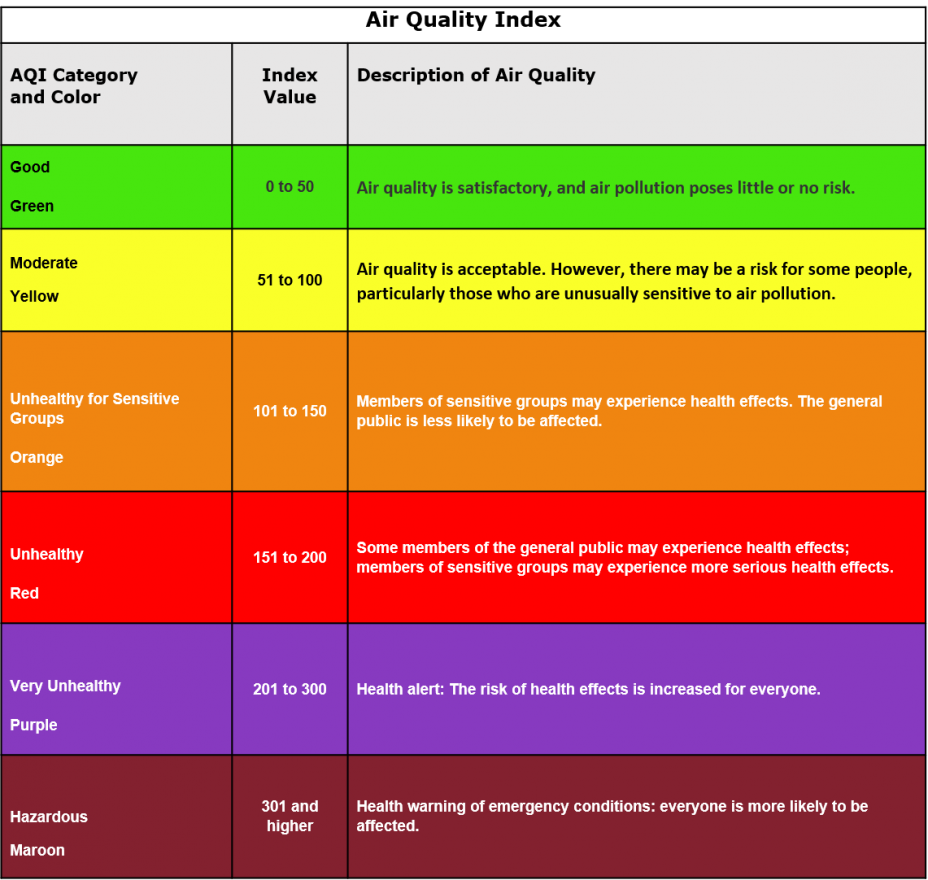

In [20]:
# create `AQI_lavel` column
bins = [0, 50, 100, 150, 200, 300, float('inf')]
labels = ['Good', 'Moderate', 'Unhealthy for sensitive group', 'Unhealthy', 'Very Unhealthy', 'Hazardous']

df['AQI_category'] = pd.cut(df['AQI'], bins=bins, labels=labels, right=False)

df

,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station,AQI,AQI_category
timestamp,,,,,,,,,,,,,,,
2013-03-01 00:00:00,5.0,14.0,4.0,12.0,200.0,85.0,-0.5,1024.5,-21.4,0.0,NNW,5.7,Nongzhanguan,27.0,Good
2013-03-01 01:00:00,8.0,12.0,6.0,14.0,200.0,84.0,-0.7,1025.1,-22.1,0.0,NW,3.9,Nongzhanguan,26.0,Good
2013-03-01 02:00:00,3.0,6.0,5.0,14.0,200.0,83.0,-1.2,1025.3,-24.6,0.0,NNW,5.3,Nongzhanguan,26.0,Good
2013-03-01 03:00:00,5.0,5.0,5.0,14.0,200.0,84.0,-1.4,1026.2,-25.5,0.0,N,4.9,Nongzhanguan,26.0,Good
2013-03-01 04:00:00,5.0,5.0,6.0,21.0,200.0,77.0,-1.9,1027.1,-24.5,0.0,NNW,3.2,Nongzhanguan,24.0,Good
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-02-28 19:00:00,13.0,37.0,3.0,36.0,400.0,60.0,12.5,1013.5,-16.2,0.0,NW,2.4,Guanyuan,66.0,Moderate
2017-02-28 20:00:00,20.0,43.0,4.0,48.0,500.0,43.0,11.6,1013.6,-15.1,0.0,WNW,0.9,Guanyuan,62.0,Moderate
2017-02-28 21:00:00,16.0,33.0,5.0,39.0,500.0,50.0,10.8,1014.2,-13.3,0.0,NW,1.1,Guanyuan,59.0,Moderate
